In [1]:
import bisect

from dataclasses import dataclass
from pathlib import Path
from random import Random

from pybigo import draw_comp
from pyinstrument import Profiler

In [2]:
def get_repeat(dpow=8, seed=742):
    rng = Random(seed)
    l = []
    i = 0
    while True:
        e = rng.randint(0, int(10 ** dpow))
        if e in l:
            break
        l.append(e)
        i += 1
    return i, e

In [3]:
def get_repeat_sorted(dpow=8, seed=742):
    rng = Random(seed)
    l = []
    i = 0
    while True:
        e = rng.randint(0, int(10 ** dpow))
        ind = bisect.bisect_left(l, e)
        try:
            if e == l[ind]:
                break
        except IndexError:
            pass
        l.insert(ind, e)
        i += 1
    return i, e

In [4]:
def get_repeat_set(dpow=8, seed=742):
    rng = Random(seed)
    s = set()
    i = 0
    while True:
        e = rng.randint(0, int(10 ** dpow))
        if e in s:
            break
        s.add(e)
        i += 1
    return i, e

In [5]:
def get_repeat_biglist(dpow=8, seed=742):
    rng = Random(seed)
    k = int(10 ** dpow)
    l = [0] * k
    i = 0
    while True:
        e = rng.randint(0, k)
        l[e] += 1
        if l[e] > 1:
            break
        i += 1
    return i, e

In [6]:
get_repeat(), get_repeat_sorted(), get_repeat_set(), get_repeat_biglist()

((10514, 17135814), (10514, 17135814), (10514, 17135814), (10514, 17135814))

In [7]:
%timeit get_repeat()

785 ms ± 16.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%timeit get_repeat_sorted()

30.1 ms ± 3.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
%timeit get_repeat_set()

12.2 ms ± 848 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
%timeit get_repeat_biglist()

569 ms ± 47.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


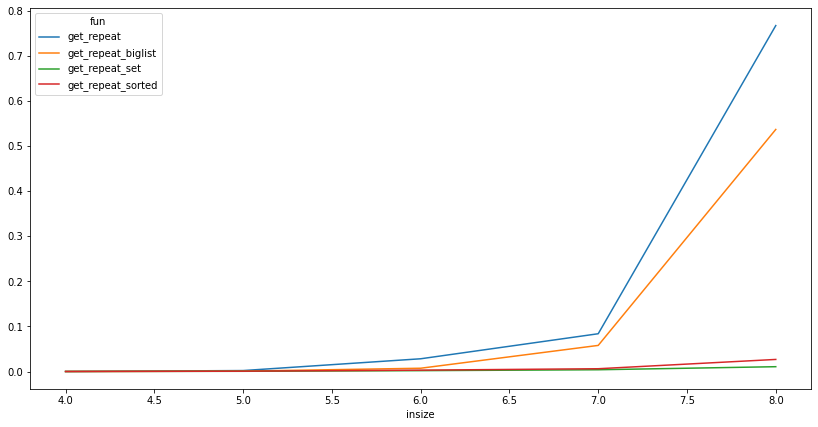

In [11]:
draw_comp(
    [get_repeat, get_repeat_set, get_repeat_sorted, get_repeat_biglist],
    [4, 5, 6, 7, 8],
    3,
)

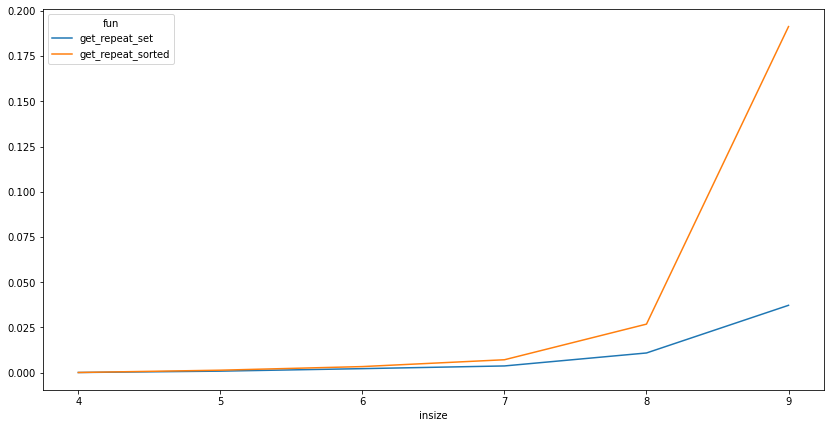

In [12]:
draw_comp(
    [get_repeat_set, get_repeat_sorted],
    [4, 5, 6, 7, 8, 9],
    5,
)

In [13]:
p = Profiler()
p.start()
get_repeat()
p.stop()

In [ ]:
# p.open_in_browser()

In [14]:
from searchers import LinFinder, LogFinder, HashFinder, BigFinder

In [16]:
LinFinder().get_repeat(), LogFinder().get_repeat(), HashFinder().get_repeat(), BigFinder().get_repeat()

((10514, 17135814), (10514, 17135814), (10514, 17135814), (10514, 17135814))

In [17]:
p = Profiler()
p.start()
LinFinder(8.5).get_repeat()
p.stop()

In [20]:
with Profiler() as p:
    BigFinder(8.5).get_repeat()
# p.open_in_browser()

In [21]:
with Profiler() as p:
    LogFinder(9).get_repeat()
# p.open_in_browser()

In [22]:
with Profiler() as p:
    HashFinder(10).get_repeat()
# p.open_in_browser()

In [23]:
recs = p.last_session.frame_records

In [24]:
len(recs)

403

In [25]:
from memory_profiler import memory_usage
from time import sleep
from gc import collect

In [26]:
def f():
    # a function that with growing
    # memory consumption
    a = [0] * 150_000
    sleep(0.1)
    b = a * 5
    sleep(0.1)
    c = b * 5
    return a

In [28]:
for _ in range(5):
    print(memory_usage(f))

[186.7265625, 186.75390625, 186.75390625, 186.75390625, 186.75390625]
[186.75390625, 186.75390625, 186.75390625, 186.75390625, 215.0859375]
[215.0859375, 215.0859375, 215.0859375, 215.0859375, 215.0859375]
[215.0859375, 215.0859375, 215.0859375, 215.0859375, 215.0859375]
[215.0859375, 215.0859375, 215.0859375, 215.0859375, 215.0859375]


In [29]:
for _ in range(5):
    collect()
    print(memory_usage(f))

[215.0859375, 215.0859375, 215.0859375, 215.0859375, 215.0859375]
[215.0859375, 215.0859375, 215.0859375, 215.0859375, 215.0859375]
[215.0859375, 215.0859375, 215.0859375, 215.0859375, 215.0859375]
[215.0859375, 215.09765625, 215.09765625, 215.09765625, 215.09765625]
[215.09765625, 215.09765625, 215.09765625, 215.09765625, 215.09765625]


In [5]:
for pref, cls in [("log", LogFinder), ("hash", HashFinder), ("big", BigFinder)]:
    script = Path("linprof.py").read_text().replace(LinFinder.__name__, cls.__name__)
    Path(f"{pref}prof.py").write_text(script)

In [30]:
from scipy.spatial import KDTree
import numpy as np
import pandas as pd

In [31]:
def tree_query(data_size, ndim, input_size, balance=True):
    rng = np.random.RandomState(742)
    data = rng.random((data_size, ndim))
    tree = KDTree(data, balanced_tree=balance)
    tree.query(rng.random((input_size, ndim)))

In [32]:
with Profiler() as p:
    tree_query(1_000_000, 4, 10_000)
# p.open_in_browser()

In [33]:
scipy_recs = []
for frame, duration in p.last_session.frame_records:
    for line in frame:
        if "scipy/spatial/kdtree.py" in line:
            scipy_recs.append({"entry": line.split("\x00")[-1], "dur": duration})

In [34]:
pd.DataFrame(scipy_recs).groupby("entry").sum()

,dur
entry,
330,0.873325
340,0.048864


In [35]:
from itertools import product

In [36]:
def get_dur_df(file_name, profiler):
    recs = []
    for frame, duration in profiler.last_session.frame_records:
        for line in frame:
            if file_name in line:
                recs.append({"entry": line.split("\x00")[-1], "dur": duration})
    return pd.DataFrame(recs).groupby("entry").sum()

In [ ]:
dfs = []
for msize, ndim, balance, _ in product(
    [1, 5, 10, 15, 20], [3, 4, 8, 16], [True, False], range(5)
):
    with Profiler() as p:
        tree_query(msize * 10_000, ndim, 100, balance)
    dfs.append(
        get_dur_df("scipy/spatial/kdtree.py", p).assign(
            ndim=ndim, msize=msize, balance=balance
        )
    )

In [ ]:
piv_df = (
    pd.concat(dfs)
    .reset_index()
    .pivot_table(
        index=["ndim", "msize"], columns=["entry", "balance"], values="dur", aggfunc="median"
    )
    .rename(columns={"330": "build", "340": "query"})
    .fillna(0)
)

In [ ]:
piv_df.style.background_gradient(axis=None)  